# Architecture Playground
This notebook is a duplicate of `5 Optimizer Playground`. The end goal is to increase accuracy by tinkering with the architecture of the CNN.

(This beautiful article)[https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7] explains how to test different architectures

#### Imports and functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pdb

train_path = '..//data//helen//train_rotated//'
test_path = '..//data//helen//test_rotated//'
num_classes = 4

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras import optimizers

def plot_figures(figures, nrows=1, ncols=1, size=8):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(size,size))
    for ind,title in enumerate(figures):
        axeslist[ind].imshow(figures[title], cmap=plt.gray())
        axeslist[ind].set_title(title)
        axeslist[ind].set_axis_off()
    plt.tight_layout() # optional
    
def plot_train_history(history):
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

x_train = np.load(train_path+'x_train_rotated_bilinear.npy')
y_train = np.load(train_path+'y_train_rotated_bilinear.npy')
x_test = np.load(test_path+'x_test_rotated_bilinear.npy')
y_test = np.load(test_path+'y_test_rotated_bilinear.npy')

# Current Best (standardized, Adam) - 0.9455 (epoch 56)
Scaling - Standardize (subtract mean pixel value and divide by standard deviation)

Optimizer - Adam

We will use the same model architecture as the previous notebook, 4-Class-CNN. We just want to make sure everything is working as expected and test the speed improvements from using images in RAM

#### Define Train function

In [46]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='sgd', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
        
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'], index+1))
    return history, model

#### Define Model

In [52]:
model_4 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_36 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_48 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_37 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_49 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 16)       

#### Execute Training

Epoch 1/100
63/63 [==============================] - 8s 120ms/step - loss: 2.9896 - acc: 0.3873 - val_loss: 1.3847 - val_acc: 0.2553
Epoch 2/100
63/63 [==============================] - 5s 79ms/step - loss: 1.1223 - acc: 0.5374 - val_loss: 1.3792 - val_acc: 0.3008
Epoch 3/100
63/63 [==============================] - 5s 79ms/step - loss: 0.9594 - acc: 0.6045 - val_loss: 1.3068 - val_acc: 0.4538
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.8058 - acc: 0.6719 - val_loss: 1.1811 - val_acc: 0.5053
Epoch 5/100
63/63 [==============================] - 5s 78ms/step - loss: 0.6880 - acc: 0.7201 - val_loss: 1.0537 - val_acc: 0.5508
Epoch 6/100
63/63 [==============================] - 5s 77ms/step - loss: 0.5774 - acc: 0.7755 - val_loss: 0.9371 - val_acc: 0.6152
Epoch 7/100
63/63 [==============================] - 5s 79ms/step - loss: 0.4663 - acc: 0.8213 - val_loss: 0.6642 - val_acc: 0.7470
Epoch 8/100
63/63 [==============================] - 5s 77ms/step - loss: 0

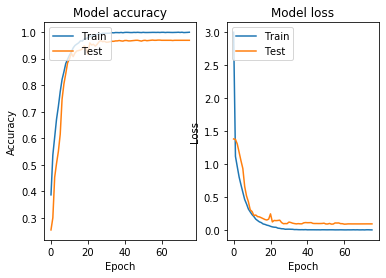

Best val_acc - 0.9455 (epoch 56)


In [53]:
# opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)   # default settings
# opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_4 = train(model_4, opt=opt)

# New Architectures

## Model 1: Conv-Conv-Pool, Conv-Conv-Pool, Dense - 0.9250 (epoch 74)
(This is like the original model from `4 Load Images into Memory`)
VGG Model

#### Define Train function

In [9]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=15, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
                
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [5]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_1.summary()

W0823 14:42:47.911655 19712 deprecation.py:506] From C:\Users\kendy\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0

#### Execute Training

Epoch 1/100
63/63 [==============================] - 8s 131ms/step - loss: 9.5738 - acc: 0.3471 - val_loss: 1.3178 - val_acc: 0.4258
Epoch 2/100
63/63 [==============================] - 5s 76ms/step - loss: 1.2098 - acc: 0.4778 - val_loss: 1.2176 - val_acc: 0.5227
Epoch 3/100
63/63 [==============================] - 5s 76ms/step - loss: 1.0604 - acc: 0.5619 - val_loss: 1.0722 - val_acc: 0.5917
Epoch 4/100
63/63 [==============================] - 5s 75ms/step - loss: 0.9187 - acc: 0.6340 - val_loss: 1.0124 - val_acc: 0.6174
Epoch 5/100
63/63 [==============================] - 5s 75ms/step - loss: 0.8146 - acc: 0.6811 - val_loss: 0.9565 - val_acc: 0.6205
Epoch 6/100
63/63 [==============================] - 5s 75ms/step - loss: 0.7289 - acc: 0.7214 - val_loss: 0.8444 - val_acc: 0.6833
Epoch 7/100
63/63 [==============================] - 5s 75ms/step - loss: 0.6500 - acc: 0.7502 - val_loss: 0.7423 - val_acc: 0.7061
Epoch 8/100
63/63 [==============================] - 5s 75ms/step - loss: 0

63/63 [==============================] - 5s 76ms/step - loss: 0.0071 - acc: 0.9987 - val_loss: 0.3245 - val_acc: 0.9227
Epoch 60/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0067 - acc: 0.9990 - val_loss: 0.3264 - val_acc: 0.9235
Epoch 61/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0064 - acc: 0.9989 - val_loss: 0.3324 - val_acc: 0.9242
Epoch 62/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0073 - acc: 0.9983 - val_loss: 0.3223 - val_acc: 0.9212
Epoch 63/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0071 - acc: 0.9985 - val_loss: 0.3321 - val_acc: 0.9227
Epoch 64/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0091 - acc: 0.9979 - val_loss: 0.3259 - val_acc: 0.9212
Epoch 65/100
62/63 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9981
Epoch 00065: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
63/63 [==============================] - 5s 7

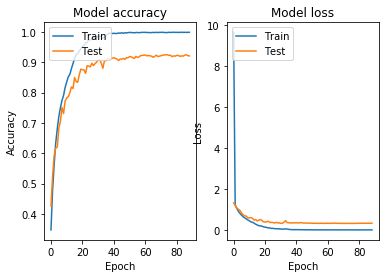

TypeError: unsupported format string passed to list.__format__

In [8]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_1 = train(model_1, opt=opt)

## Model 2: Conv - Pool, Conv - Pool, Dense  - 0.8644 (epoch 39)
Take the past model and make it shallower.

#### Define Train function

In [10]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=15, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
                
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model
Made it deeper and added a Dense(1024) layer at the end

In [17]:
model_2 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
#     Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
#     Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_16 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_30 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 16)       

#### Execute Training

Epoch 1/100
63/63 [==============================] - 5s 74ms/step - loss: 12.2571 - acc: 0.2760 - val_loss: 1.3444 - val_acc: 0.3871
Epoch 2/100
63/63 [==============================] - 3s 50ms/step - loss: 1.3288 - acc: 0.3505 - val_loss: 1.2945 - val_acc: 0.4023
Epoch 3/100
63/63 [==============================] - 3s 51ms/step - loss: 1.2819 - acc: 0.3882 - val_loss: 1.2585 - val_acc: 0.4303
Epoch 4/100
63/63 [==============================] - 3s 50ms/step - loss: 1.2413 - acc: 0.4092 - val_loss: 1.2131 - val_acc: 0.4409
Epoch 5/100
63/63 [==============================] - 3s 50ms/step - loss: 1.1988 - acc: 0.4448 - val_loss: 1.1680 - val_acc: 0.5136
Epoch 6/100
63/63 [==============================] - 3s 50ms/step - loss: 1.1429 - acc: 0.4884 - val_loss: 1.1055 - val_acc: 0.5417
Epoch 7/100
63/63 [==============================] - 3s 50ms/step - loss: 1.0661 - acc: 0.5246 - val_loss: 1.0407 - val_acc: 0.5742
Epoch 8/100
63/63 [==============================] - 3s 50ms/step - loss: 0

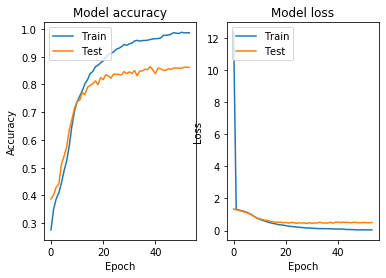

Best val_acc - 0.8644 (epoch 39)


In [18]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_2 = train(model_2, opt=opt)

## Model 3: m2 - Dense(1024) -> Dense(128)  - 0.8902 (epoch 44)
Take the past model and make it smaller.

#### Define Train function

In [46]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='sgd', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
        
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'], index+1))
    return history, model

#### Define Model

In [52]:
model_4 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_36 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_48 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_37 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_49 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 16)       

#### Execute Training

Epoch 1/100
63/63 [==============================] - 8s 120ms/step - loss: 2.9896 - acc: 0.3873 - val_loss: 1.3847 - val_acc: 0.2553
Epoch 2/100
63/63 [==============================] - 5s 79ms/step - loss: 1.1223 - acc: 0.5374 - val_loss: 1.3792 - val_acc: 0.3008
Epoch 3/100
63/63 [==============================] - 5s 79ms/step - loss: 0.9594 - acc: 0.6045 - val_loss: 1.3068 - val_acc: 0.4538
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.8058 - acc: 0.6719 - val_loss: 1.1811 - val_acc: 0.5053
Epoch 5/100
63/63 [==============================] - 5s 78ms/step - loss: 0.6880 - acc: 0.7201 - val_loss: 1.0537 - val_acc: 0.5508
Epoch 6/100
63/63 [==============================] - 5s 77ms/step - loss: 0.5774 - acc: 0.7755 - val_loss: 0.9371 - val_acc: 0.6152
Epoch 7/100
63/63 [==============================] - 5s 79ms/step - loss: 0.4663 - acc: 0.8213 - val_loss: 0.6642 - val_acc: 0.7470
Epoch 8/100
63/63 [==============================] - 5s 77ms/step - loss: 0

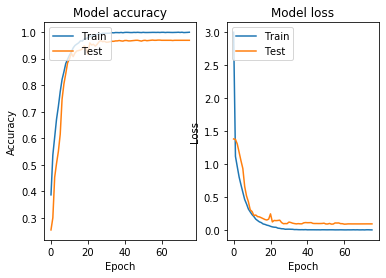

Best val_acc - 0.9455 (epoch 56)


In [53]:
# opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)   # default settings
# opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_4 = train(model_4, opt=opt)

## Model 4: best - more filters  - 0.8932 (epoch 47)
Going back to the best model and adding more filters.

Okay this one probably overfit. We have 100% training accuracy..

#### Define Train function

In [23]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=15, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
                
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [24]:
model_4 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
#     Dense(128),
#     Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_20 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_38 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_21 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_39 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 32)       

#### Execute Training

Epoch 1/100
63/63 [==============================] - 11s 176ms/step - loss: 10.1945 - acc: 0.3021 - val_loss: 1.3665 - val_acc: 0.3212
Epoch 2/100
63/63 [==============================] - 7s 112ms/step - loss: 1.2474 - acc: 0.4576 - val_loss: 1.4042 - val_acc: 0.3000
Epoch 3/100
63/63 [==============================] - 7s 114ms/step - loss: 1.0896 - acc: 0.5472 - val_loss: 1.1943 - val_acc: 0.4947
Epoch 4/100
63/63 [==============================] - 7s 111ms/step - loss: 0.9571 - acc: 0.6099 - val_loss: 1.0826 - val_acc: 0.5553
Epoch 5/100
63/63 [==============================] - 7s 110ms/step - loss: 0.8220 - acc: 0.6758 - val_loss: 0.9859 - val_acc: 0.6038
Epoch 6/100
63/63 [==============================] - 7s 110ms/step - loss: 0.7020 - acc: 0.7301 - val_loss: 0.8516 - val_acc: 0.6886
Epoch 7/100
63/63 [==============================] - 7s 111ms/step - loss: 0.6052 - acc: 0.7654 - val_loss: 0.8035 - val_acc: 0.6947
Epoch 8/100
63/63 [==============================] - 7s 112ms/step 

Epoch 56/100
63/63 [==============================] - 7s 113ms/step - loss: 0.0031 - acc: 0.9999 - val_loss: 0.4984 - val_acc: 0.8864
Epoch 57/100
63/63 [==============================] - 7s 111ms/step - loss: 0.0031 - acc: 0.9999 - val_loss: 0.4983 - val_acc: 0.8879
Epoch 58/100
63/63 [==============================] - 7s 112ms/step - loss: 0.0033 - acc: 0.9999 - val_loss: 0.4981 - val_acc: 0.8886
Epoch 59/100
62/63 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9999
Epoch 00059: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
63/63 [==============================] - 7s 111ms/step - loss: 0.0028 - acc: 0.9999 - val_loss: 0.4956 - val_acc: 0.8894
Epoch 60/100
63/63 [==============================] - 7s 111ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4950 - val_acc: 0.8894
Epoch 61/100
63/63 [==============================] - 7s 112ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4953 - val_acc: 0.8886
Epoch 62/100
63/63 [==================

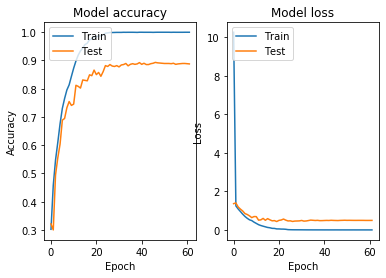

Best val_acc - 0.8932 (epoch 47)


In [25]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_4 = train(model_4, opt=opt)

## Model 5: best - too many filters  - 0.9258 (epoch 60)
Last model had too many filters maybe. Tone it down a bit.


#### Define Train function

In [26]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=15, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
                
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [27]:
model_4 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='same'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
#     Dense(128),
#     Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_44 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 24)      3480      
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 128, 24)      96        
_________________________________________________________________
activation_45 (Activation)   (None, 128, 128, 24)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 24)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 8s 128ms/step - loss: 11.9144 - acc: 0.3320 - val_loss: 1.3112 - val_acc: 0.3970
Epoch 2/100
63/63 [==============================] - 6s 88ms/step - loss: 1.1977 - acc: 0.4947 - val_loss: 1.2275 - val_acc: 0.4735
Epoch 3/100
63/63 [==============================] - 6s 88ms/step - loss: 1.0447 - acc: 0.5803 - val_loss: 1.2128 - val_acc: 0.4636
Epoch 4/100
63/63 [==============================] - 5s 87ms/step - loss: 0.8773 - acc: 0.6665 - val_loss: 1.1383 - val_acc: 0.5038
Epoch 5/100
63/63 [==============================] - 6s 88ms/step - loss: 0.7701 - acc: 0.7070 - val_loss: 0.9162 - val_acc: 0.6470
Epoch 6/100
63/63 [==============================] - 6s 88ms/step - loss: 0.6813 - acc: 0.7416 - val_loss: 0.8412 - val_acc: 0.6955
Epoch 7/100
63/63 [==============================] - 5s 86ms/step - loss: 0.6219 - acc: 0.7628 - val_loss: 0.7248 - val_acc: 0.7258
Epoch 8/100
63/63 [==============================] - 5s 86ms/step - loss: 

Epoch 58/100
63/63 [==============================] - 5s 86ms/step - loss: 0.0051 - acc: 0.9992 - val_loss: 0.3271 - val_acc: 0.9220
Epoch 59/100
63/63 [==============================] - 5s 86ms/step - loss: 0.0049 - acc: 0.9991 - val_loss: 0.3252 - val_acc: 0.9227
Epoch 60/100
63/63 [==============================] - 5s 86ms/step - loss: 0.0049 - acc: 0.9995 - val_loss: 0.3269 - val_acc: 0.9258
Epoch 61/100
63/63 [==============================] - 5s 87ms/step - loss: 0.0045 - acc: 0.9995 - val_loss: 0.3274 - val_acc: 0.9220
Epoch 62/100
63/63 [==============================] - 6s 88ms/step - loss: 0.0053 - acc: 0.9989 - val_loss: 0.3242 - val_acc: 0.9167
Epoch 63/100
63/63 [==============================] - 6s 89ms/step - loss: 0.0042 - acc: 0.9996 - val_loss: 0.3273 - val_acc: 0.9189
Epoch 64/100
62/63 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9991- ETA: 2s -
Epoch 00064: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
63/63 [=============

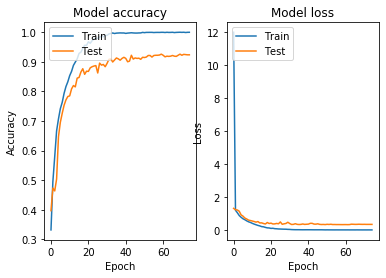

Best val_acc - 0.9258 (epoch 60)


In [28]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_4 = train(model_4, opt=opt)

## Model 6: best - no padding  - 0.9667 (epoch 39)
Best model padding on any conv layers

#### Define Model

In [29]:
model_6 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_6.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_28 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_50 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_29 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_51 (Activation)   (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 62, 62, 16)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 8s 127ms/step - loss: 2.3246 - acc: 0.3002 - val_loss: 1.3725 - val_acc: 0.3038
Epoch 2/100
63/63 [==============================] - 5s 73ms/step - loss: 1.2400 - acc: 0.4165 - val_loss: 1.3698 - val_acc: 0.2985
Epoch 3/100
63/63 [==============================] - 5s 72ms/step - loss: 1.0909 - acc: 0.5250 - val_loss: 1.3327 - val_acc: 0.3697
Epoch 4/100
63/63 [==============================] - 5s 74ms/step - loss: 0.9694 - acc: 0.5851 - val_loss: 1.3706 - val_acc: 0.3826
Epoch 5/100
63/63 [==============================] - 5s 74ms/step - loss: 0.8669 - acc: 0.6425 - val_loss: 1.1553 - val_acc: 0.4644
Epoch 6/100
63/63 [==============================] - 5s 73ms/step - loss: 0.7350 - acc: 0.7026 - val_loss: 0.8324 - val_acc: 0.6629
Epoch 7/100
63/63 [==============================] - 5s 73ms/step - loss: 0.6194 - acc: 0.7529 - val_loss: 0.7386 - val_acc: 0.6962
Epoch 8/100
63/63 [==============================] - 5s 74ms/step - loss: 0

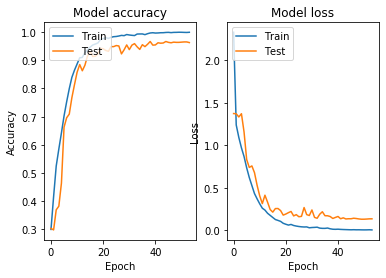

Best val_acc - 0.9667 (epoch 39)


In [30]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_6 = train(model_6, opt=opt)

## Model 7: m6 Dense(512)  - 0.9811 (epoch 39)
reduce

#### Define Model

In [31]:
model_7 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(512),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_7.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_34 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_58 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_35 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_59 (Activation)   (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 16)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 7s 110ms/step - loss: 2.0198 - acc: 0.3190 - val_loss: 1.3667 - val_acc: 0.3189
Epoch 2/100
63/63 [==============================] - 5s 72ms/step - loss: 1.2386 - acc: 0.4505 - val_loss: 1.4645 - val_acc: 0.2515
Epoch 3/100
63/63 [==============================] - 5s 73ms/step - loss: 1.0747 - acc: 0.5479 - val_loss: 1.3424 - val_acc: 0.3500
Epoch 4/100
63/63 [==============================] - 5s 73ms/step - loss: 0.8556 - acc: 0.6596 - val_loss: 1.1422 - val_acc: 0.4977ss - ETA: 0s - loss: 0.8618 - acc: 0.6
Epoch 5/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6883 - acc: 0.7335 - val_loss: 0.9972 - val_acc: 0.6053
Epoch 6/100
63/63 [==============================] - 4s 71ms/step - loss: 0.5731 - acc: 0.7819 - val_loss: 0.7295 - val_acc: 0.7477
Epoch 7/100
63/63 [==============================] - 5s 74ms/step - loss: 0.4515 - acc: 0.8265 - val_loss: 0.4841 - val_acc: 0.8174
Epoch 8/100
63/63 [==================

63/63 [==============================] - 5s 78ms/step - loss: 0.0115 - acc: 0.9967 - val_loss: 0.0627 - val_acc: 0.9803
Epoch 00054: early stopping


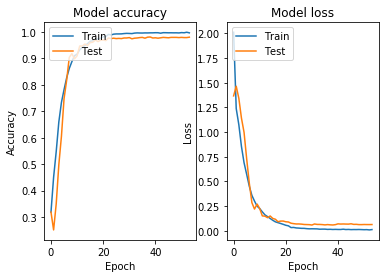

Best val_acc - 0.9811 (epoch 39)


In [32]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_7 = train(model_7, opt=opt)

## Model 8: m7 Dense(256) - 0.9606 (epoch 33)
reduce

#### Define Model

In [35]:
model_8 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(256),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_8.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_46 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_74 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_47 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_75 (Activation)   (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 62, 62, 16)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 7s 115ms/step - loss: 1.7864 - acc: 0.3383 - val_loss: 1.3855 - val_acc: 0.2530
Epoch 2/100
63/63 [==============================] - 5s 73ms/step - loss: 1.2013 - acc: 0.4888 - val_loss: 1.3683 - val_acc: 0.3758
Epoch 3/100
63/63 [==============================] - 5s 74ms/step - loss: 1.0466 - acc: 0.5760 - val_loss: 1.3054 - val_acc: 0.3780
Epoch 4/100
63/63 [==============================] - 4s 71ms/step - loss: 0.8540 - acc: 0.6609 - val_loss: 1.2623 - val_acc: 0.4045
Epoch 5/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6987 - acc: 0.7259 - val_loss: 1.0066 - val_acc: 0.5818
Epoch 6/100
63/63 [==============================] - 5s 72ms/step - loss: 0.5949 - acc: 0.7697 - val_loss: 1.0184 - val_acc: 0.5667
Epoch 7/100
63/63 [==============================] - 5s 72ms/step - loss: 0.5340 - acc: 0.7946 - val_loss: 0.8003 - val_acc: 0.6765
Epoch 8/100
63/63 [==============================] - 5s 72ms/step - loss: 0

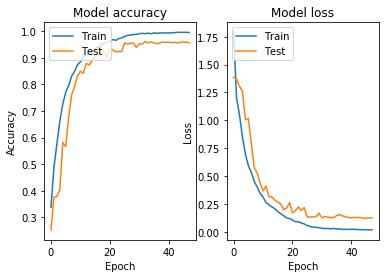

Best val_acc - 0.9606 (epoch 33)


In [36]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_8 = train(model_8, opt=opt)

## Model 9: m8 - more filters - 0.9902 (epoch 42)
Maybe more filters will work better this time.

You bet your ass it does 😎

#### Define Model

In [37]:
model_9 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(24, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(256),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_9.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_52 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_82 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_53 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_83 (Activation)   (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 62, 62, 16)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 10s 154ms/step - loss: 2.0371 - acc: 0.2744 - val_loss: 1.3728 - val_acc: 0.3326
Epoch 2/100
63/63 [==============================] - 5s 77ms/step - loss: 1.3371 - acc: 0.3546 - val_loss: 1.3690 - val_acc: 0.3364
Epoch 3/100
63/63 [==============================] - 5s 77ms/step - loss: 1.2082 - acc: 0.4660 - val_loss: 1.3647 - val_acc: 0.3258
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.9578 - acc: 0.6127 - val_loss: 1.3419 - val_acc: 0.3455
Epoch 5/100
63/63 [==============================] - 5s 75ms/step - loss: 0.7645 - acc: 0.7014 - val_loss: 1.1181 - val_acc: 0.5439
Epoch 6/100
63/63 [==============================] - 5s 79ms/step - loss: 0.6213 - acc: 0.7605 - val_loss: 0.8408 - val_acc: 0.6591
Epoch 7/100
63/63 [==============================] - 5s 77ms/step - loss: 0.4846 - acc: 0.8169 - val_loss: 0.4267 - val_acc: 0.8591
Epoch 8/100
63/63 [==============================] - 5s 77ms/step - loss: 

Epoch 55/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0111 - acc: 0.9966 - val_loss: 0.0327 - val_acc: 0.9879
Epoch 56/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0111 - acc: 0.9970 - val_loss: 0.0392 - val_acc: 0.9879
Epoch 57/100
63/63 [==============================] - 5s 83ms/step - loss: 0.0126 - acc: 0.9967 - val_loss: 0.0333 - val_acc: 0.9879
Epoch 00057: early stopping


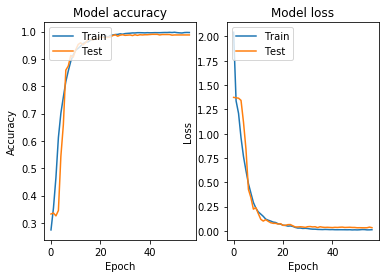

Best val_acc - 0.9902 (epoch 42)


In [38]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_9 = train(model_9, opt=opt)

## Model 10: m9 - Dense(128) - 0.9674 (epoch 40)
Repeat the above process

#### Define Model

In [39]:
model_10 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(24, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_10.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_58 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_90 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_59 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_91 (Activation)   (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 62, 62, 16)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 17s 264ms/step - loss: 1.5746 - acc: 0.3274 - val_loss: 1.3821 - val_acc: 0.2682
Epoch 2/100
63/63 [==============================] - 5s 81ms/step - loss: 1.2563 - acc: 0.4426 - val_loss: 1.3841 - val_acc: 0.2568
Epoch 3/100
63/63 [==============================] - 5s 86ms/step - loss: 1.0891 - acc: 0.5520 - val_loss: 1.3375 - val_acc: 0.3333
Epoch 4/100
63/63 [==============================] - 5s 85ms/step - loss: 0.9035 - acc: 0.6436 - val_loss: 1.1219 - val_acc: 0.5576
Epoch 5/100
63/63 [==============================] - 5s 81ms/step - loss: 0.7165 - acc: 0.7245 - val_loss: 0.7702 - val_acc: 0.7061
Epoch 6/100
63/63 [==============================] - 5s 82ms/step - loss: 0.6035 - acc: 0.7715 - val_loss: 0.5510 - val_acc: 0.8061
Epoch 7/100
63/63 [==============================] - 5s 81ms/step - loss: 0.5114 - acc: 0.8067 - val_loss: 0.4951 - val_acc: 0.8371
Epoch 8/100
63/63 [==============================] - 5s 79ms/step - loss: 

63/63 [==============================] - 6s 91ms/step - loss: 0.0157 - acc: 0.9952 - val_loss: 0.0889 - val_acc: 0.9652
Epoch 00055: early stopping


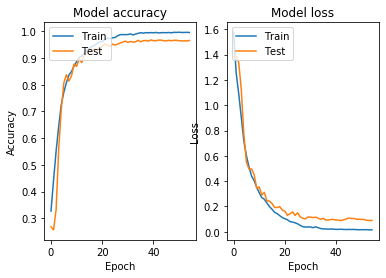

Best val_acc - 0.9674 (epoch 40)


In [41]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_10 = train(model_10, opt=opt)

## Model 11: m10 - more filters  - 0.9924 (epoch 67)
Repeat the above process

#### Define Model

In [42]:
model_11 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(24, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_11.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_64 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_98 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 124, 124, 24)      3480      
_________________________________________________________________
batch_normalization_65 (Batc (None, 124, 124, 24)      96        
_________________________________________________________________
activation_99 (Activation)   (None, 124, 124, 24)      0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 62, 62, 24)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 11s 167ms/step - loss: 1.6212 - acc: 0.3277 - val_loss: 1.3849 - val_acc: 0.2508
Epoch 2/100
63/63 [==============================] - 6s 93ms/step - loss: 1.1788 - acc: 0.4868 - val_loss: 1.3834 - val_acc: 0.2833
Epoch 3/100
63/63 [==============================] - 6s 94ms/step - loss: 0.9728 - acc: 0.6028 - val_loss: 1.3487 - val_acc: 0.3371
Epoch 4/100
63/63 [==============================] - 6s 94ms/step - loss: 0.7689 - acc: 0.6946 - val_loss: 1.2224 - val_acc: 0.5038
Epoch 5/100
63/63 [==============================] - 6s 95ms/step - loss: 0.5795 - acc: 0.7747 - val_loss: 0.8567 - val_acc: 0.6955
Epoch 6/100
63/63 [==============================] - 6s 95ms/step - loss: 0.4451 - acc: 0.8389 - val_loss: 0.4774 - val_acc: 0.8333
Epoch 7/100
63/63 [==============================] - 6s 93ms/step - loss: 0.3595 - acc: 0.8686 - val_loss: 0.3883 - val_acc: 0.8538
Epoch 8/100
63/63 [==============================] - 6s 93ms/step - loss: 

62/63 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9996
Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
63/63 [==============================] - 6s 94ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0374 - val_acc: 0.9902
Epoch 61/100
63/63 [==============================] - 6s 94ms/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0334 - val_acc: 0.9902
Epoch 62/100
63/63 [==============================] - 6s 98ms/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0342 - val_acc: 0.9902
Epoch 63/100
63/63 [==============================] - 6s 95ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0325 - val_acc: 0.9894
Epoch 64/100
62/63 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9990
Epoch 00064: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
63/63 [==============================] - 6s 94ms/step - loss: 0.0029 - acc: 0.9990 - val_loss: 0.0286 - val_acc: 0.9886
Epoch 65/100
63/63 [=============

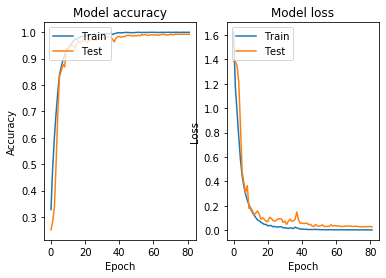

Best val_acc - 0.9924 (epoch 67)


In [43]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_11 = train(model_11, opt=opt)

## Model 12: m11 - Dense(32)  - 0.9871 (epoch 39)
Repeat the above process

#### Define Model

In [48]:
model_12 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(24, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(32),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_12.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_88 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_130 (Activation)  (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 124, 124, 24)      3480      
_________________________________________________________________
batch_normalization_89 (Batc (None, 124, 124, 24)      96        
_________________________________________________________________
activation_131 (Activation)  (None, 124, 124, 24)      0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 62, 62, 24)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 10s 154ms/step - loss: 1.4503 - acc: 0.2505 - val_loss: 1.3859 - val_acc: 0.2515
Epoch 2/100
63/63 [==============================] - 6s 94ms/step - loss: 1.3516 - acc: 0.3114 - val_loss: 1.3647 - val_acc: 0.2515
Epoch 3/100
63/63 [==============================] - 6s 94ms/step - loss: 1.1655 - acc: 0.4499 - val_loss: 1.2365 - val_acc: 0.3886
Epoch 4/100
63/63 [==============================] - 6s 95ms/step - loss: 0.9368 - acc: 0.5886 - val_loss: 1.0630 - val_acc: 0.5341
Epoch 5/100
63/63 [==============================] - 6s 98ms/step - loss: 0.7255 - acc: 0.7056 - val_loss: 0.7613 - val_acc: 0.6955
Epoch 6/100
63/63 [==============================] - 6s 95ms/step - loss: 0.5441 - acc: 0.7866 - val_loss: 0.5096 - val_acc: 0.8038
Epoch 7/100
63/63 [==============================] - 6s 97ms/step - loss: 0.4457 - acc: 0.8269 - val_loss: 0.3409 - val_acc: 0.8773
Epoch 8/100
63/63 [==============================] - 6s 95ms/step - loss: 

Epoch 00054: early stopping


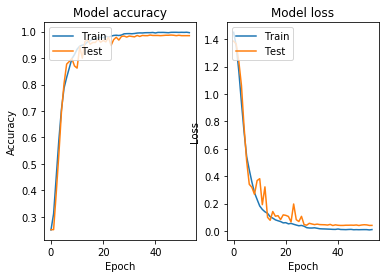

Best val_acc - 0.9871 (epoch 39)


In [49]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_12 = train(model_12, opt=opt)

# Results
The fastest optimizer was Adam, achieving a val_acc of 0.9682 at epoch 28.
The best performing optimizer is also Adam, with a val_acc of 0.9697 at epoch 56 :)